**Spark notebook**

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))


# Print function docstrings

help(start_spark)
help(stop_spark)
help(display_spark)
help(show_as_html)

Help on function start_spark in module __main__:

start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)
    Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)

Help on function stop_spark in module __main__:

stop_spark()
    Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).

Help on function display_spark in module __main__:

display_spark()
    Display the status of the active Spark session if one is currently running.

Help on function show_as_html in module __main__:

show_as_html(df, n=20)
    Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n 

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.ui.port,4162
spark.driver.memory,4g
spark.driver.extraJavaOptions,-Dderby.system.home=/tmp/ndu31/spark/
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.app.startTime,1663796137577
spark.executor.id,driver
spark.sql.warehouse.dir,file:/users/home/ndu31/spark-warehouse
spark.executor.cores,2


In [185]:
# Write your imports and code here or insert cells below

from pyspark.sql import functions as F
from pyspark.sql.types import *
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime, date

In [4]:
name = "ndu31"
stations = (
spark.read.format("parquet")
.load(f"hdfs:///user/{name}/outputs/ghcnd/stations.parquet"))
stations.show(15,False)



+-----------+----------+----+--------+---------+---------+-------------------+--------+------------+------+--------------------+----------+---------+--------+--------------+----+----+----+----+----+--------------+
|ID         |STATE_CODE|CODE|LATITUDE|LONGITUDE|ELEVATION|STATION_NAME       |GSN_FLAG|HCN_CRN_FLAG|WMO_ID|COUNTRY_NAME        |STATE_NAME|FIRSTYEAR|LASTYEAR|TOTAL_ELEMENTS|PRCP|SNOW|SNWD|TMAX|TMIN|OTHER_ELEMENTS|
+-----------+----------+----+--------+---------+---------+-------------------+--------+------------+------+--------------------+----------+---------+--------+--------------+----+----+----+----+----+--------------+
|AE000041196|N/A       |AE  |25.333  |55.517   |34.0     |SHARJAH INTER. AIRP|GSN     |            |41196 |United Arab Emirates|          |1944     |2022    |4             |1   |0   |0   |1   |1   |4             |
|AEM00041218|N/A       |AE  |24.262  |55.609   |264.9    |AL AIN INTL        |        |            |41218 |United Arab Emirates|          |1994 

In [ ]:
#Question 1a

In [5]:
stations.count()

122047

In [19]:
active_2021 = (
stations
.where((stations.FIRSTYEAR <= 2021) &
      (stations.LASTYEAR >= 2021)))

active_2021.count()

42588

In [27]:
gsn_count = (
stations
.where(stations.GSN_FLAG == "GSN"))

gsn_count.count()

991

In [24]:
hcn_crn_count = (
stations
.select("HCN_CRN_FLAG")
.groupBy("HCN_CRN_FLAG")
.count())

hcn_crn_count.show()

+------------+------+
|HCN_CRN_FLAG| count|
+------------+------+
|         HCN|  1218|
|            |120829|
+------------+------+



In [28]:
network_count = (
    stations
    .where((stations.GSN_FLAG == "GSN") &
          (stations.HCN_CRN_FLAG == "HCN")

))
network_count.count()

14

In [18]:
country_info = (
spark.read.format("text")
.load("hdfs:///data/ghcnd/ghcnd-countries.txt"))
countries = country_info.select(country_info.value.substr(1,2).cast("string").alias("CODE"),
                    country_info.value.substr(4,60).cast("string").alias("COUNTRY_NAME")
                    )

countries.cache
countries = (
stations
.select(["ID", "CODE"])
.groupBy("CODE")
.agg({"ID":"count"})
.withColumnRenamed("count(ID)", "STATION_COUNT")
.join(
countries,
on="CODE",
how="left"))

countries.show()

+----+-------------+--------------------+
|CODE|STATION_COUNT|        COUNTRY_NAME|
+----+-------------+--------------------+
|  TI|           62|         Tajikistan |
|  BB|            1|           Barbados |
|  BG|           10|          Bangladesh|
|  CA|         9096|             Canada |
|  MX|         5249|             Mexico |
|  MZ|           19|         Mozambique |
|  NI|           10|             Nigeria|
|  SW|         1721|             Sweden |
|  UG|            8|              Uganda|
|  WQ|            1|Wake Island [Unit...|
|  GH|           18|               Ghana|
|  GM|         1123|            Germany |
|  CH|          228|             China  |
|  HU|           10|            Hungary |
|  TO|           10|               Togo |
|  TU|           59|             Turkey |
|  BN|            9|              Benin |
|  PC|            1|Pitcairn Islands ...|
|  NH|            6|            Vanuatu |
|  WI|            1|     Western Sahara |
+----+-------------+--------------

In [25]:
countries.write.parquet(f"hdfs:///user/{name}/outputs/ghcnd/countries.parquet", mode="overwrite")
!hdfs dfs -ls /user/ndu31/outputs/ghcnd/

Found 2 items
drwxr-xr-x   - ndu31 ndu31          0 2022-09-22 16:11 /user/ndu31/outputs/ghcnd/countries.parquet
drwxr-xr-x   - ndu31 ndu31          0 2022-09-21 21:23 /user/ndu31/outputs/ghcnd/stations.parquet


In [22]:
state_info = (
spark.read.format("text")
.load("hdfs:///data/ghcnd/ghcnd-states.txt"))
states = state_info.select(state_info.value.substr(1,2).cast("string").alias("STATE_CODE"),
                    state_info.value.substr(4,46).cast("string").alias("STATE_NAME")
                    )
states = (
stations
.select(["ID", "STATE_CODE"])
.groupBy("STATE_CODE")
.agg({"ID":"count"})
.withColumnRenamed("count(ID)", "STATION_COUNT")
.join(
states,
on="STATE_CODE",
how="left"))

states.show()

+----------+-------------+--------------------+
|STATE_CODE|STATION_COUNT|          STATE_NAME|
+----------+-------------+--------------------+
|        NT|          137|NORTHWEST TERRITO...|
|        CA|         2977|          CALIFORNIA|
|        OK|         1046|            OKLAHOMA|
|        MN|         1797|           MINNESOTA|
|       N/A|        43969|                null|
|        ND|          563|        NORTH DAKOTA|
|        NH|          453|       NEW HAMPSHIRE|
|        OH|         1287|                OHIO|
|        WI|         1238|           WISCONSIN|
|        MB|          726|            MANITOBA|
|        AZ|         1604|             ARIZONA|
|        FM|           38|          MICRONESIA|
|        MH|           21|    MARSHALL ISLANDS|
|        NM|         2130|          NEW MEXICO|
|        AL|         1059|ALABAMA          ...|
|        AR|          901|            ARKANSAS|
|        FL|         2021|             FLORIDA|
|        VI|           64|      VIRGIN I

In [26]:
states.write.parquet(f"hdfs:///user/{name}/outputs/ghcnd/states.parquet", mode="overwrite")
!hdfs dfs -ls /user/ndu31/outputs/ghcnd/

Found 3 items
drwxr-xr-x   - ndu31 ndu31          0 2022-09-22 16:11 /user/ndu31/outputs/ghcnd/countries.parquet
drwxr-xr-x   - ndu31 ndu31          0 2022-09-22 16:12 /user/ndu31/outputs/ghcnd/states.parquet
drwxr-xr-x   - ndu31 ndu31          0 2022-09-21 21:23 /user/ndu31/outputs/ghcnd/stations.parquet


In [27]:
southern_stations = (
stations
.where(stations.LATITUDE < 0))

southern_stations.count()


25337

In [30]:
US_stations = (
    stations
    .where(
        (stations.COUNTRY_NAME.contains("United States")) &
        (stations.COUNTRY_NAME != "United States")
))


US_stations.show()
US_stations.count()


+-----------+----------+----+--------+---------+---------+--------------------+--------+------------+------+--------------------+--------------------+---------+--------+--------------+----+----+----+----+----+--------------+
|         ID|STATE_CODE|CODE|LATITUDE|LONGITUDE|ELEVATION|        STATION_NAME|GSN_FLAG|HCN_CRN_FLAG|WMO_ID|        COUNTRY_NAME|          STATE_NAME|FIRSTYEAR|LASTYEAR|TOTAL_ELEMENTS|PRCP|SNOW|SNWD|TMAX|TMIN|OTHER_ELEMENTS|
+-----------+----------+----+--------+---------+---------+--------------------+--------+------------+------+--------------------+--------------------+---------+--------+--------------+----+----+----+----+----+--------------+
|AQC00914869|        AS|  AQ| -14.333| -170.716|      3.0|   TAFUNA AP TUTUILA|        |            |      |American Samoa [U...|      AMERICAN SAMOA|     1956|    1966|            10|   1|   1|   1|   1|   1|            10|
|CQC00914855|        MP|  CQ|  15.116|  145.716|     65.5|      SAIPAN INTL AP|        |            

354

In [33]:
#Question 2 - using the Haversine Formula in Python (bearing and distance between two GPS points)


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    """
    #convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    #haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2)**2) + cos(lat2) * cos(lat2) * (sin(dlon/2)** 2)
    c = 2 * asin(sqrt(a))
    #Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

distance_func = F.udf(haversine)


In [36]:
NZ_stations = (
    stations
    .where(
        stations.COUNTRY_NAME == "New Zealand")
    .select(["ID", "STATION_NAME", "LATITUDE", "LONGITUDE"])
)

NZ_stations.show()

+-----------+-------------------+--------+---------+
|         ID|       STATION_NAME|LATITUDE|LONGITUDE|
+-----------+-------------------+--------+---------+
|NZ000093417|    PARAPARAUMU AWS|   -40.9|  174.983|
|NZM00093781|  CHRISTCHURCH INTL| -43.489|  172.532|
|NZ000939450|CAMPBELL ISLAND AWS|  -52.55|  169.167|
|NZM00093929| ENDERBY ISLAND AWS| -50.483|    166.3|
|NZ000933090|   NEW PLYMOUTH AWS| -39.017|  174.183|
|NZ000093844|INVERCARGILL AIRPOR| -46.417|  168.333|
|NZ000093994| RAOUL ISL/KERMADEC|  -29.25| -177.917|
|NZ000937470|         TARA HILLS| -44.517|    169.9|
|NZ000939870|CHATHAM ISLANDS AWS|  -43.95| -176.567|
|NZ000093292| GISBORNE AERODROME|  -38.65|  177.983|
|NZM00093439|WELLINGTON AERO AWS| -41.333|    174.8|
|NZ000936150| HOKITIKA AERODROME| -42.717|  170.983|
|NZM00093678|           KAIKOURA| -42.417|    173.7|
|NZM00093110|  AUCKLAND AERO AWS|   -37.0|    174.8|
|NZ000093012|            KAITAIA|   -35.1|  173.267|
+-----------+-------------------+--------+----

In [42]:
two_stations = (
    NZ_stations
    .crossJoin(NZ_stations)
    .toDF("ID_1", "STATION_1", "LATITUDE_1", "LONGITUDE_1", "ID_2", "STATION_2", "LATITUDE_2", "LONGITUDE_2")
)

two_stations = (
    two_stations
    .where(two_stations.ID_1 > two_stations.ID_2)
)

In [57]:
distance_table = (
    two_stations
    .withColumn("DISTANCE", distance_func(
        two_stations.LONGITUDE_1, two_stations.LATITUDE_1,
        two_stations.LONGITUDE_2, two_stations.LATITUDE_2   
    ))

)

distance_table = (
    distance_table
    .withColumn("DISTANCE", distance_table.DISTANCE.cast(FloatType()))
)

distance_table.show()


+-----------+-------------------+----------+-----------+-----------+-------------------+----------+-----------+---------+
|       ID_1|          STATION_1|LATITUDE_1|LONGITUDE_1|       ID_2|          STATION_2|LATITUDE_2|LONGITUDE_2| DISTANCE|
+-----------+-------------------+----------+-----------+-----------+-------------------+----------+-----------+---------+
|NZ000093417|    PARAPARAUMU AWS|     -40.9|    174.983|NZ000093292| GISBORNE AERODROME|    -38.65|    177.983|361.21634|
|NZ000093417|    PARAPARAUMU AWS|     -40.9|    174.983|NZ000093012|            KAITAIA|     -35.1|    173.267| 663.5871|
|NZM00093781|  CHRISTCHURCH INTL|   -43.489|    172.532|NZ000093417|    PARAPARAUMU AWS|     -40.9|    174.983| 354.0118|
|NZM00093781|  CHRISTCHURCH INTL|   -43.489|    172.532|NZ000939450|CAMPBELL ISLAND AWS|    -52.55|    169.167|1033.0074|
|NZM00093781|  CHRISTCHURCH INTL|   -43.489|    172.532|NZ000933090|   NEW PLYMOUTH AWS|   -39.017|    174.183|517.33594|
|NZM00093781|  CHRISTCHU

In [58]:
min_dist = distance_table.sort("DISTANCE",ascending = True)
min_dist.show(1,False)

+-----------+-------------------+----------+-----------+-----------+---------------+----------+-----------+--------+
|ID_1       |STATION_1          |LATITUDE_1|LONGITUDE_1|ID_2       |STATION_2      |LATITUDE_2|LONGITUDE_2|DISTANCE|
+-----------+-------------------+----------+-----------+-----------+---------------+----------+-----------+--------+
|NZM00093439|WELLINGTON AERO AWS|-41.333   |174.8      |NZ000093417|PARAPARAUMU AWS|-40.9     |174.983    |50.54424|
+-----------+-------------------+----------+-----------+-----------+---------------+----------+-----------+--------+
only showing top 1 row



In [74]:
#Question 3

!hdfs getconf -confKey "dfs.blocksize"


134217728


In [76]:
!hdfs fsck /data/ghcnd/daily/2022.csv.gz -files -blocks

Connecting to namenode via http://masternode2:9870/fsck?ugi=ndu31&files=1&blocks=1&path=%2Fdata%2Fghcnd%2Fdaily%2F2022.csv.gz
FSCK started by ndu31 (auth:SIMPLE) from /192.168.40.11 for path /data/ghcnd/daily/2022.csv.gz at Thu Sep 22 18:48:12 NZST 2022

/data/ghcnd/daily/2022.csv.gz 88195367 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073787808_46988 len=88195367 Live_repl=8


Status: HEALTHY
 Number of data-nodes:	32
 Number of racks:		1
 Total dirs:			0
 Total symlinks:		0

Replicated Blocks:
 Total size:	88195367 B
 Total files:	1
 Total blocks (validated):	1 (avg. block size 88195367 B)
 Minimally replicated blocks:	1 (100.0 %)
 Over-replicated blocks:	0 (0.0 %)
 Under-replicated blocks:	0 (0.0 %)
 Mis-replicated blocks:		0 (0.0 %)
 Default replication factor:	4
 Average block replication:	8.0
 Missing blocks:		0
 Corrupt blocks:		0
 Missing replicas:		0 (0.0 %)
 Blocks queued for replication:	0

Erasure Coded Block Groups:
 

In [77]:
!hdfs fsck /data/ghcnd/daily/2021.csv.gz -files -blocks

Connecting to namenode via http://masternode2:9870/fsck?ugi=ndu31&files=1&blocks=1&path=%2Fdata%2Fghcnd%2Fdaily%2F2021.csv.gz
FSCK started by ndu31 (auth:SIMPLE) from /192.168.40.11 for path /data/ghcnd/daily/2021.csv.gz at Thu Sep 22 18:48:48 NZST 2022

/data/ghcnd/daily/2021.csv.gz 159598394 bytes, replicated: replication=8, 2 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073787806_46986 len=134217728 Live_repl=8
1. BP-700027894-132.181.129.68-1626517177804:blk_1073787807_46987 len=25380666 Live_repl=8


Status: HEALTHY
 Number of data-nodes:	32
 Number of racks:		1
 Total dirs:			0
 Total symlinks:		0

Replicated Blocks:
 Total size:	159598394 B
 Total files:	1
 Total blocks (validated):	2 (avg. block size 79799197 B)
 Minimally replicated blocks:	2 (100.0 %)
 Over-replicated blocks:	0 (0.0 %)
 Under-replicated blocks:	0 (0.0 %)
 Mis-replicated blocks:		0 (0.0 %)
 Default replication factor:	4
 Average block replication:	8.0
 Missing blocks:		0
 Corrupt blocks:		0


In [71]:
daily_schema = StructType([
    StructField('ID', StringType()),
    StructField('DATE', StringType()),
    StructField('ELEMENT', StringType()),
    StructField('VALUE', FloatType()),
    StructField('MEASUREMENT_FLAG', StringType()),
    StructField('QUALITY_FLAG', StringType()),
    StructField('SOURCE_FLAG', StringType()),
    StructField('OBSERVATION_TIME', StringType())
])

In [79]:
daily_2022 = (spark.read.format("com.databricks.spark.csv")
              .option("header", "false")
              .option("inferSchema", "false")
              .schema(daily_schema)
              .load("hdfs:///data/ghcnd/daily/2022.csv.gz"))

daily_2022.count()
           

19648456

In [80]:
daily_2021 = (spark.read.format("com.databricks.spark.csv")
              .option("header", "false")
              .option("inferSchema", "false")
              .schema(daily_schema)
              .load("hdfs:///data/ghcnd/daily/2021.csv.gz"))
daily_2021.count()  

35917254

In [89]:
daily_2014_2022 = (spark.read.format("com.databricks.spark.csv")
              .option("header", "false")
              .option("inferSchema", "false")
              .schema(daily_schema)
              .load("hdfs:///data/ghcnd/daily/20{1[4-9],2[0-2]}.csv.gz"))
daily_2014_2022.count() 

303501016

In [90]:
#Question 4

daily_all = (spark.read.format("com.databricks.spark.csv")
              .option("header", "false")
              .option("inferSchema", "false")
              .schema(daily_schema)
              .load("hdfs:///data/ghcnd/daily/*.csv.gz"))
daily_all.count() 

3018826504

In [92]:
core_count = (daily_all
             .select(["ID","ELEMENT"])
             .filter(
                (daily_all.ELEMENT == "PRCP") |
                (daily_all.ELEMENT == "SNOW") |
                (daily_all.ELEMENT == "SNWD") |
                (daily_all.ELEMENT == "TMAX") |
                (daily_all.ELEMENT == "TMIN")    
             ).groupby("ELEMENT")
             .agg({"ID":"count"})
             .withColumnRenamed("count(ID)","ELEMENT_COUNT")
             .orderBy("ELEMENT_COUNT", ascending = False))

core_count.show()

+-------+-------------+
|ELEMENT|ELEMENT_COUNT|
+-------+-------------+
|   PRCP|   1048156273|
|   TMAX|    447084093|
|   TMIN|    445687425|
|   SNOW|    344268930|
|   SNWD|    290998195|
+-------+-------------+



In [93]:
correspond = (
        daily_all
        .select(["ID", "DATE", "ELEMENT"])
        .filter(
            (daily_all.ELEMENT == "TMAX") |
            (daily_all.ELEMENT == "TMIN"))
    .groupby("ID","DATE")
    .pivot("ELEMENT")
    .agg({"ELEMENT":"count"}))

correspond.show()

+-----------+--------+----+----+
|         ID|    DATE|TMAX|TMIN|
+-----------+--------+----+----+
|AE000041196|19440622|   1|   1|
|AE000041196|19440722|   1|   1|
|AE000041196|19560309|   1|   1|
|AE000041196|19571113|   1|   1|
|AE000041196|19580617|   1|null|
|AE000041196|19600317|   1|   1|
|AE000041196|19780117|   1|null|
|AE000041196|19820320|   1|null|
|AE000041196|19880318|   1|null|
|AE000041196|19880610|   1|   1|
|AE000041196|19900308|   1|   1|
|AE000041196|19900503|   1|   1|
|AE000041196|19910112|   1|   1|
|AE000041196|19930727|   1|   1|
|AE000041196|19940721|   1|   1|
|AE000041196|19971109|   1|   1|
|AE000041196|19971202|   1|   1|
|AE000041196|19990810|   1|null|
|AE000041196|20000413|   1|   1|
|AE000041196|20010415|   1|   1|
+-----------+--------+----+----+
only showing top 20 rows



In [94]:
more_correspond = (
    correspond.filter(
        (correspond.TMIN.isNotNull()) &
        (correspond.TMAX.isNull())
        )
)

more_correspond.count()


8848299

In [96]:
more_correspond.select(F.countDistinct("ID")).show()

+------------------+
|count(DISTINCT ID)|
+------------------+
|             27678|
+------------------+



In [98]:
NZ_CORRESP = (
        daily_all
        .filter(
            (daily_all.ELEMENT == "TMAX") |
            (daily_all.ELEMENT == "TMIN"))
    .join(
    stations.select(["ID", "CODE", "STATION_NAME"]),
    on="ID",
    how="left"))



In [100]:
NZ_CORRESP = (
    NZ_CORRESP
    .filter(NZ_CORRESP.CODE == "NZ")
    .withColumn("YEAR", F.trim(F.substring(F.col("DATE"),1,4)))
)
NZ_CORRESP.show()

NZ_CORRESP.write.csv(f"hdfs:///user/{name}/outputs/ghcnd/NZ_CORRESP.csv", mode="overwrite")

+-----------+--------+-------+-----+----------------+------------+-----------+----------------+----+-------------------+----+
|         ID|    DATE|ELEMENT|VALUE|MEASUREMENT_FLAG|QUALITY_FLAG|SOURCE_FLAG|OBSERVATION_TIME|CODE|       STATION_NAME|YEAR|
+-----------+--------+-------+-----+----------------+------------+-----------+----------------+----+-------------------+----+
|NZ000936150|20100101|   TMAX|324.0|            null|        null|          S|            null|  NZ| HOKITIKA AERODROME|2010|
|NZM00093110|20100101|   TMAX|215.0|            null|        null|          S|            null|  NZ|  AUCKLAND AERO AWS|2010|
|NZM00093110|20100101|   TMIN|153.0|            null|        null|          S|            null|  NZ|  AUCKLAND AERO AWS|2010|
|NZM00093678|20100101|   TMAX|242.0|            null|        null|          S|            null|  NZ|           KAIKOURA|2010|
|NZM00093678|20100101|   TMIN| 94.0|            null|        null|          S|            null|  NZ|           KAIKOUR

In [102]:
NZ_CORRESP.count()

474654

In [101]:
!hdfs dfs -ls /user/ndu31/outputs/ghcnd/

Found 4 items
drwxr-xr-x   - ndu31 ndu31          0 2022-09-22 23:01 /user/ndu31/outputs/ghcnd/NZ_CORRESP.csv
drwxr-xr-x   - ndu31 ndu31          0 2022-09-22 16:11 /user/ndu31/outputs/ghcnd/countries.parquet
drwxr-xr-x   - ndu31 ndu31          0 2022-09-22 16:12 /user/ndu31/outputs/ghcnd/states.parquet
drwxr-xr-x   - ndu31 ndu31          0 2022-09-21 21:23 /user/ndu31/outputs/ghcnd/stations.parquet


In [103]:
years = NZ_CORRESP.groupby("ID").agg(F.min("YEAR").alias("FIRSTYEAR"), F.max("YEAR").alias("LASTYEAR"))

years.show()

+-----------+---------+--------+
|         ID|FIRSTYEAR|LASTYEAR|
+-----------+---------+--------+
|NZ000936150|     1964|    2022|
|NZ000093012|     1966|    2009|
|NZ000093292|     1962|    2022|
|NZM00093678|     1997|    2022|
|NZ000093844|     1948|    2022|
|NZ000093417|     1972|    2022|
|NZ000933090|     1944|    2022|
|NZ000093994|     1940|    2022|
|NZM00093110|     2002|    2022|
|NZ000937470|     1949|    2005|
|NZ000939870|     1956|    2008|
|NZM00093781|     1960|    2022|
|NZ000939450|     1941|    2022|
|NZM00093929|     1994|    2022|
|NZM00093439|     2002|    2022|
+-----------+---------+--------+



In [114]:
!hdfs dfs -copyToLocal /user/ndu31/outputs/ghcnd/NZ_CORRESP.csv ~/NZ_CORRESP.csv

In [117]:
!ls -l ~/NZ_CORRESP.csv

total 84992
-rw-r--r--. 1 ndu31@canterbury.ac.nz domain users@canterbury.ac.nz 340197 Sep 22 23:56 part-00000-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
-rw-r--r--. 1 ndu31@canterbury.ac.nz domain users@canterbury.ac.nz 340357 Sep 22 23:56 part-00001-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
-rw-r--r--. 1 ndu31@canterbury.ac.nz domain users@canterbury.ac.nz 354534 Sep 22 23:56 part-00002-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
-rw-r--r--. 1 ndu31@canterbury.ac.nz domain users@canterbury.ac.nz 340591 Sep 22 23:56 part-00003-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
-rw-r--r--. 1 ndu31@canterbury.ac.nz domain users@canterbury.ac.nz 344142 Sep 22 23:56 part-00004-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
-rw-r--r--. 1 ndu31@canterbury.ac.nz domain users@canterbury.ac.nz 325494 Sep 22 23:56 part-00005-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
-rw-r--r--. 1 ndu31@canterbury.ac.nz domain users@canterbury.ac.nz 635004 Sep 22 23:56 part-00006-defb3352-a15e-4e66-b339-a1

In [158]:
!wc -l ~/NZ_CORRESP.csv/*

    4997 /users/home/ndu31/NZ_CORRESP.csv/part-00000-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
    5001 /users/home/ndu31/NZ_CORRESP.csv/part-00001-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
    5194 /users/home/ndu31/NZ_CORRESP.csv/part-00002-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
    5001 /users/home/ndu31/NZ_CORRESP.csv/part-00003-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
    5051 /users/home/ndu31/NZ_CORRESP.csv/part-00004-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
    4781 /users/home/ndu31/NZ_CORRESP.csv/part-00005-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
    9416 /users/home/ndu31/NZ_CORRESP.csv/part-00006-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
    4780 /users/home/ndu31/NZ_CORRESP.csv/part-00007-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
    5581 /users/home/ndu31/NZ_CORRESP.csv/part-00008-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
    6805 /users/home/ndu31/NZ_CORRESP.csv/part-00009-defb3352-a15e-4e66-b339-a1436b15e11c-c000.csv
    9471 /

In [136]:
import pandas as pd
import os

columns = ["ID", "DATE", "ELEMENT", "VALUE", "MEASUREMENT_FLAG", "QUALITY_FLAG", "SOURCE_FLAG", "OBSERVATION_TIME", "CODE", "STATION_NAME", "YEAR"]
parts = []
for file in os.listdir(os.path.expanduser("~/NZ_CORRESP.csv/")):
    if file == "_SUCCESS":
        continue
    try:
        data = pd.read_csv(f"~/NZ_CORRESP.csv/{file}", header =None, names = columns)
        parts.append(data)
    except pd.io.common.EmptyDataError:
        pass

        

data = pd.concat(parts)
        
print(data)
        


               ID      DATE ELEMENT  VALUE  MEASUREMENT_FLAG QUALITY_FLAG  \
0     NZ000093994  19420101    TMAX  236.0               NaN          NaN   
1     NZ000093994  19420101    TMIN  157.0               NaN          NaN   
2     NZ000939450  19420101    TMAX  112.0               NaN          NaN   
3     NZ000939450  19420101    TMIN   74.0               NaN          NaN   
4     NZ000093994  19420102    TMAX  227.0               NaN          NaN   
5     NZ000093994  19420102    TMIN  180.0               NaN          NaN   
6     NZ000939450  19420102    TMAX  117.0               NaN          NaN   
7     NZ000939450  19420102    TMIN   12.0               NaN          NaN   
8     NZ000093994  19420103    TMAX  233.0               NaN          NaN   
9     NZ000093994  19420103    TMIN  148.0               NaN          NaN   
10    NZ000939450  19420103    TMAX  124.0               NaN          NaN   
11    NZ000939450  19420103    TMIN   69.0               NaN          NaN   

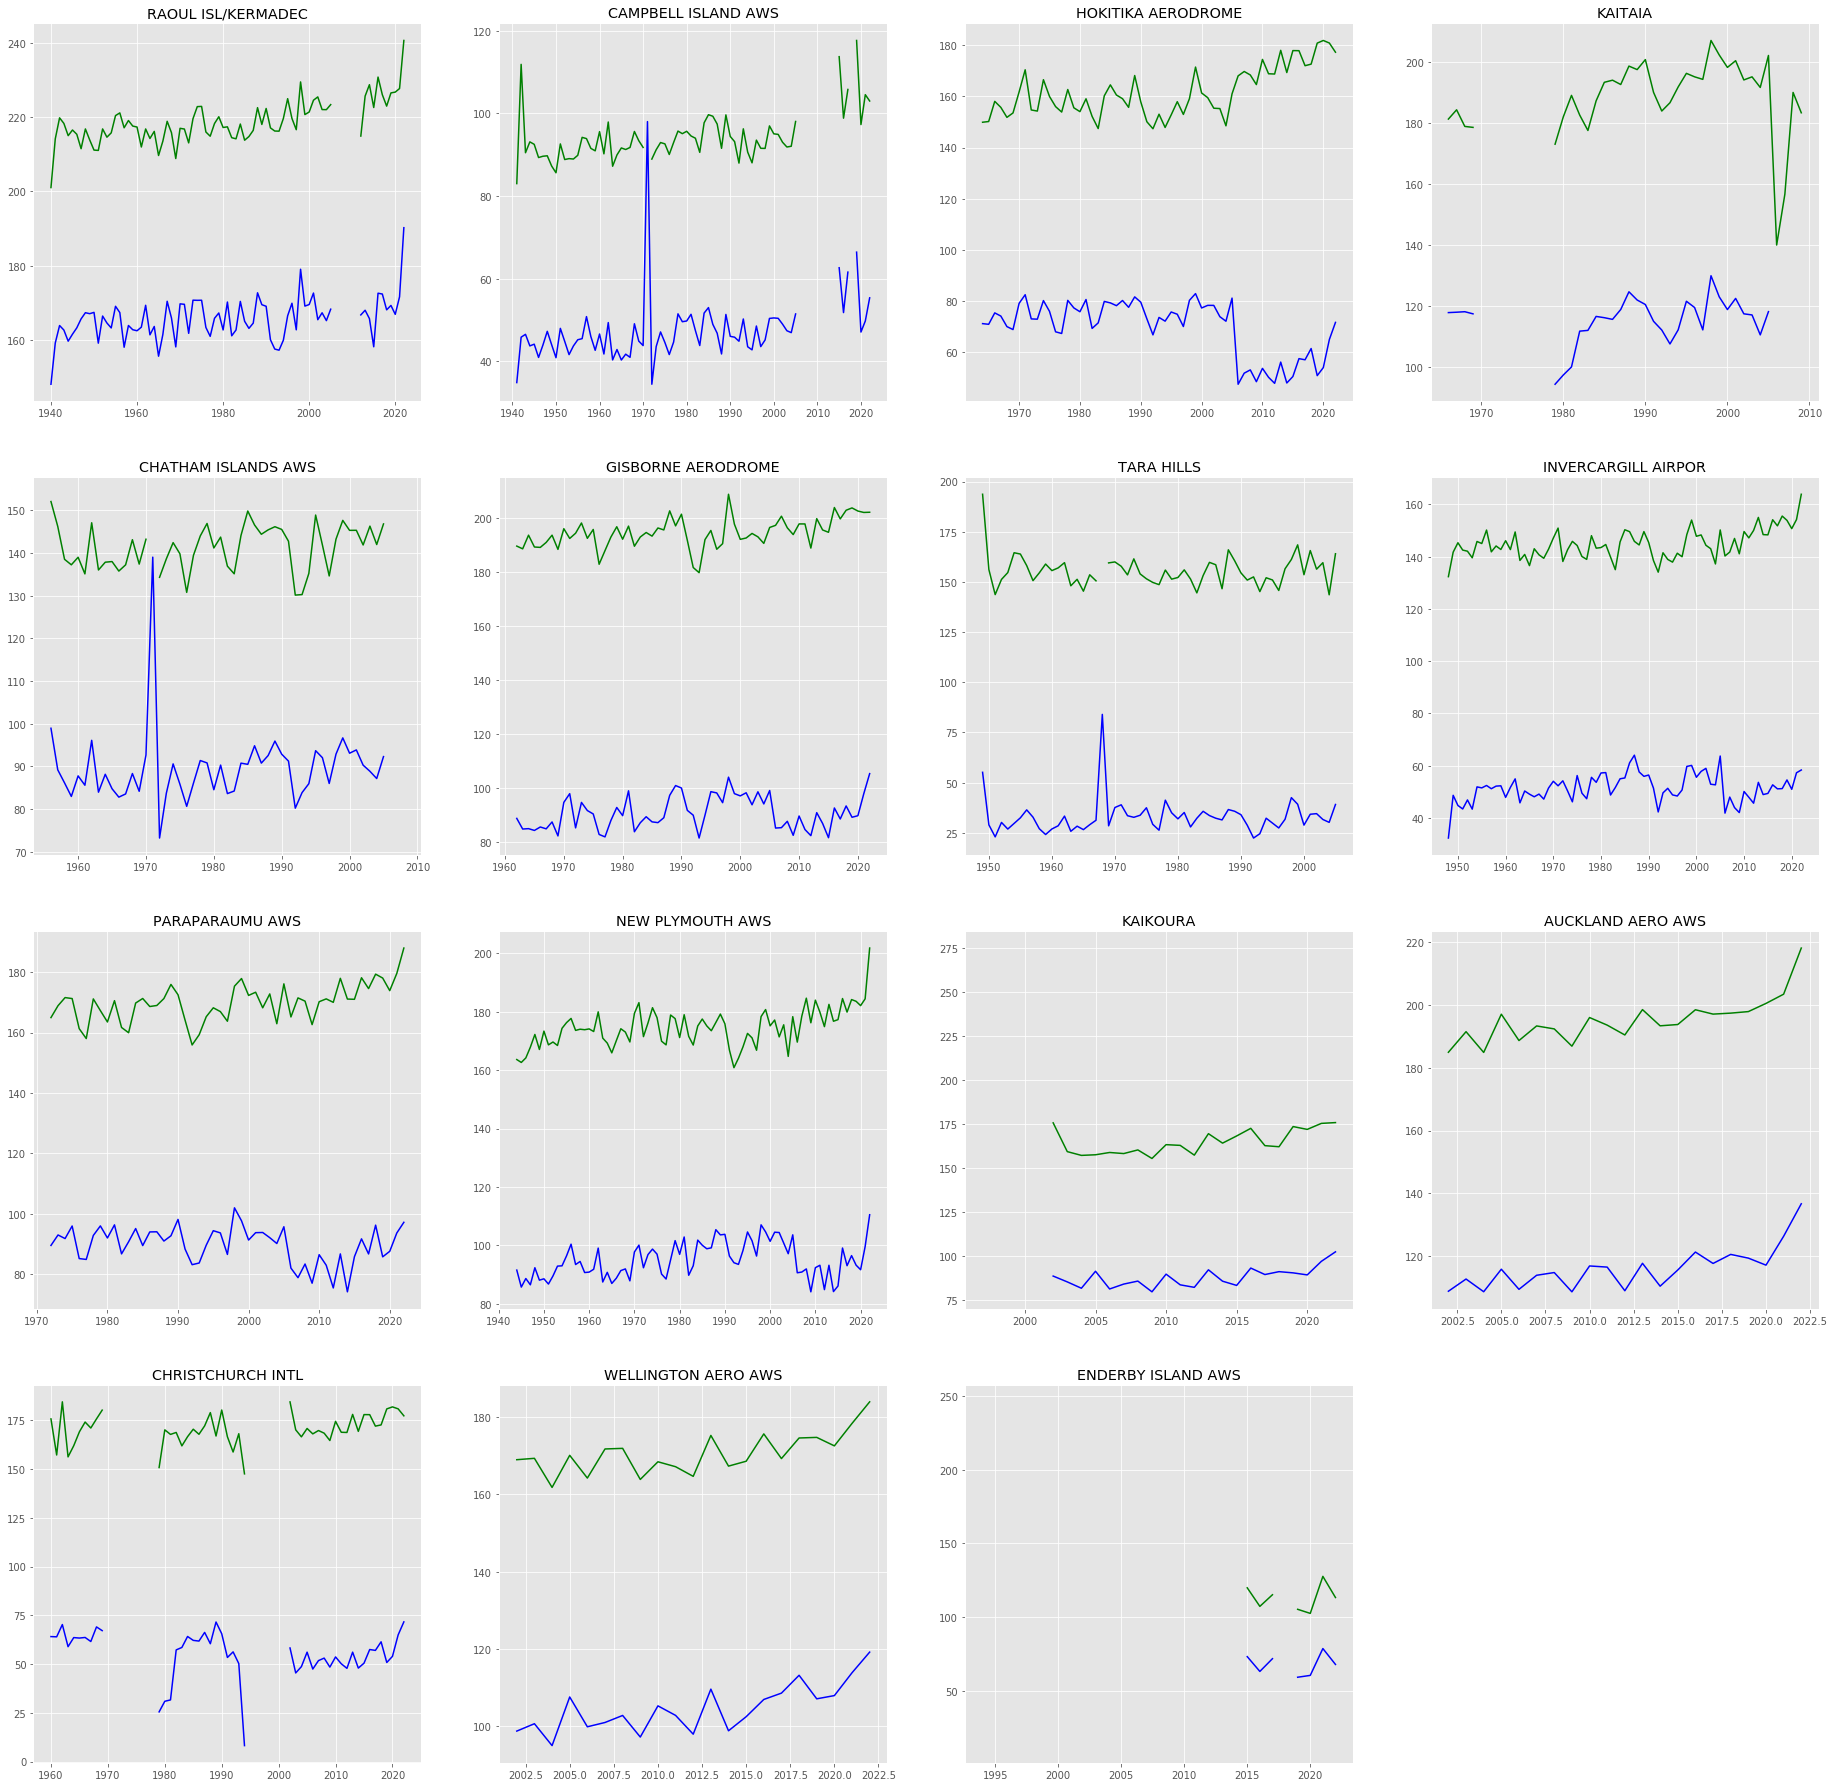

In [173]:


stations_plot = data["STATION_NAME"].unique()
fig = plt.figure(figsize=(32, 32))
plt.style.use("ggplot") 


#data["DATE"]=data["DATE"].apply(lambda x:datetime.strptime(str(x), '%Y%m%d'))

for i,NAME in enumerate(stations_plot):
    station_df = data.loc[data["STATION_NAME"] == NAME]
    station_df = pd.pivot_table(station_df,index='DATE',columns = 'ELEMENT',values='VALUE')
    station_df = station_df.assign(Date=station_df.index).resample('1D').first()
    station_df = station_df.groupby(station_df.index.year).mean()
    ax = fig.add_subplot(4,4,(1+i))
    plt.title(NAME)
    ax.plot(station_df.index,station_df['TMIN'],color='blue')
    ax.plot(station_df.index,station_df['TMAX'],color='green') 

    





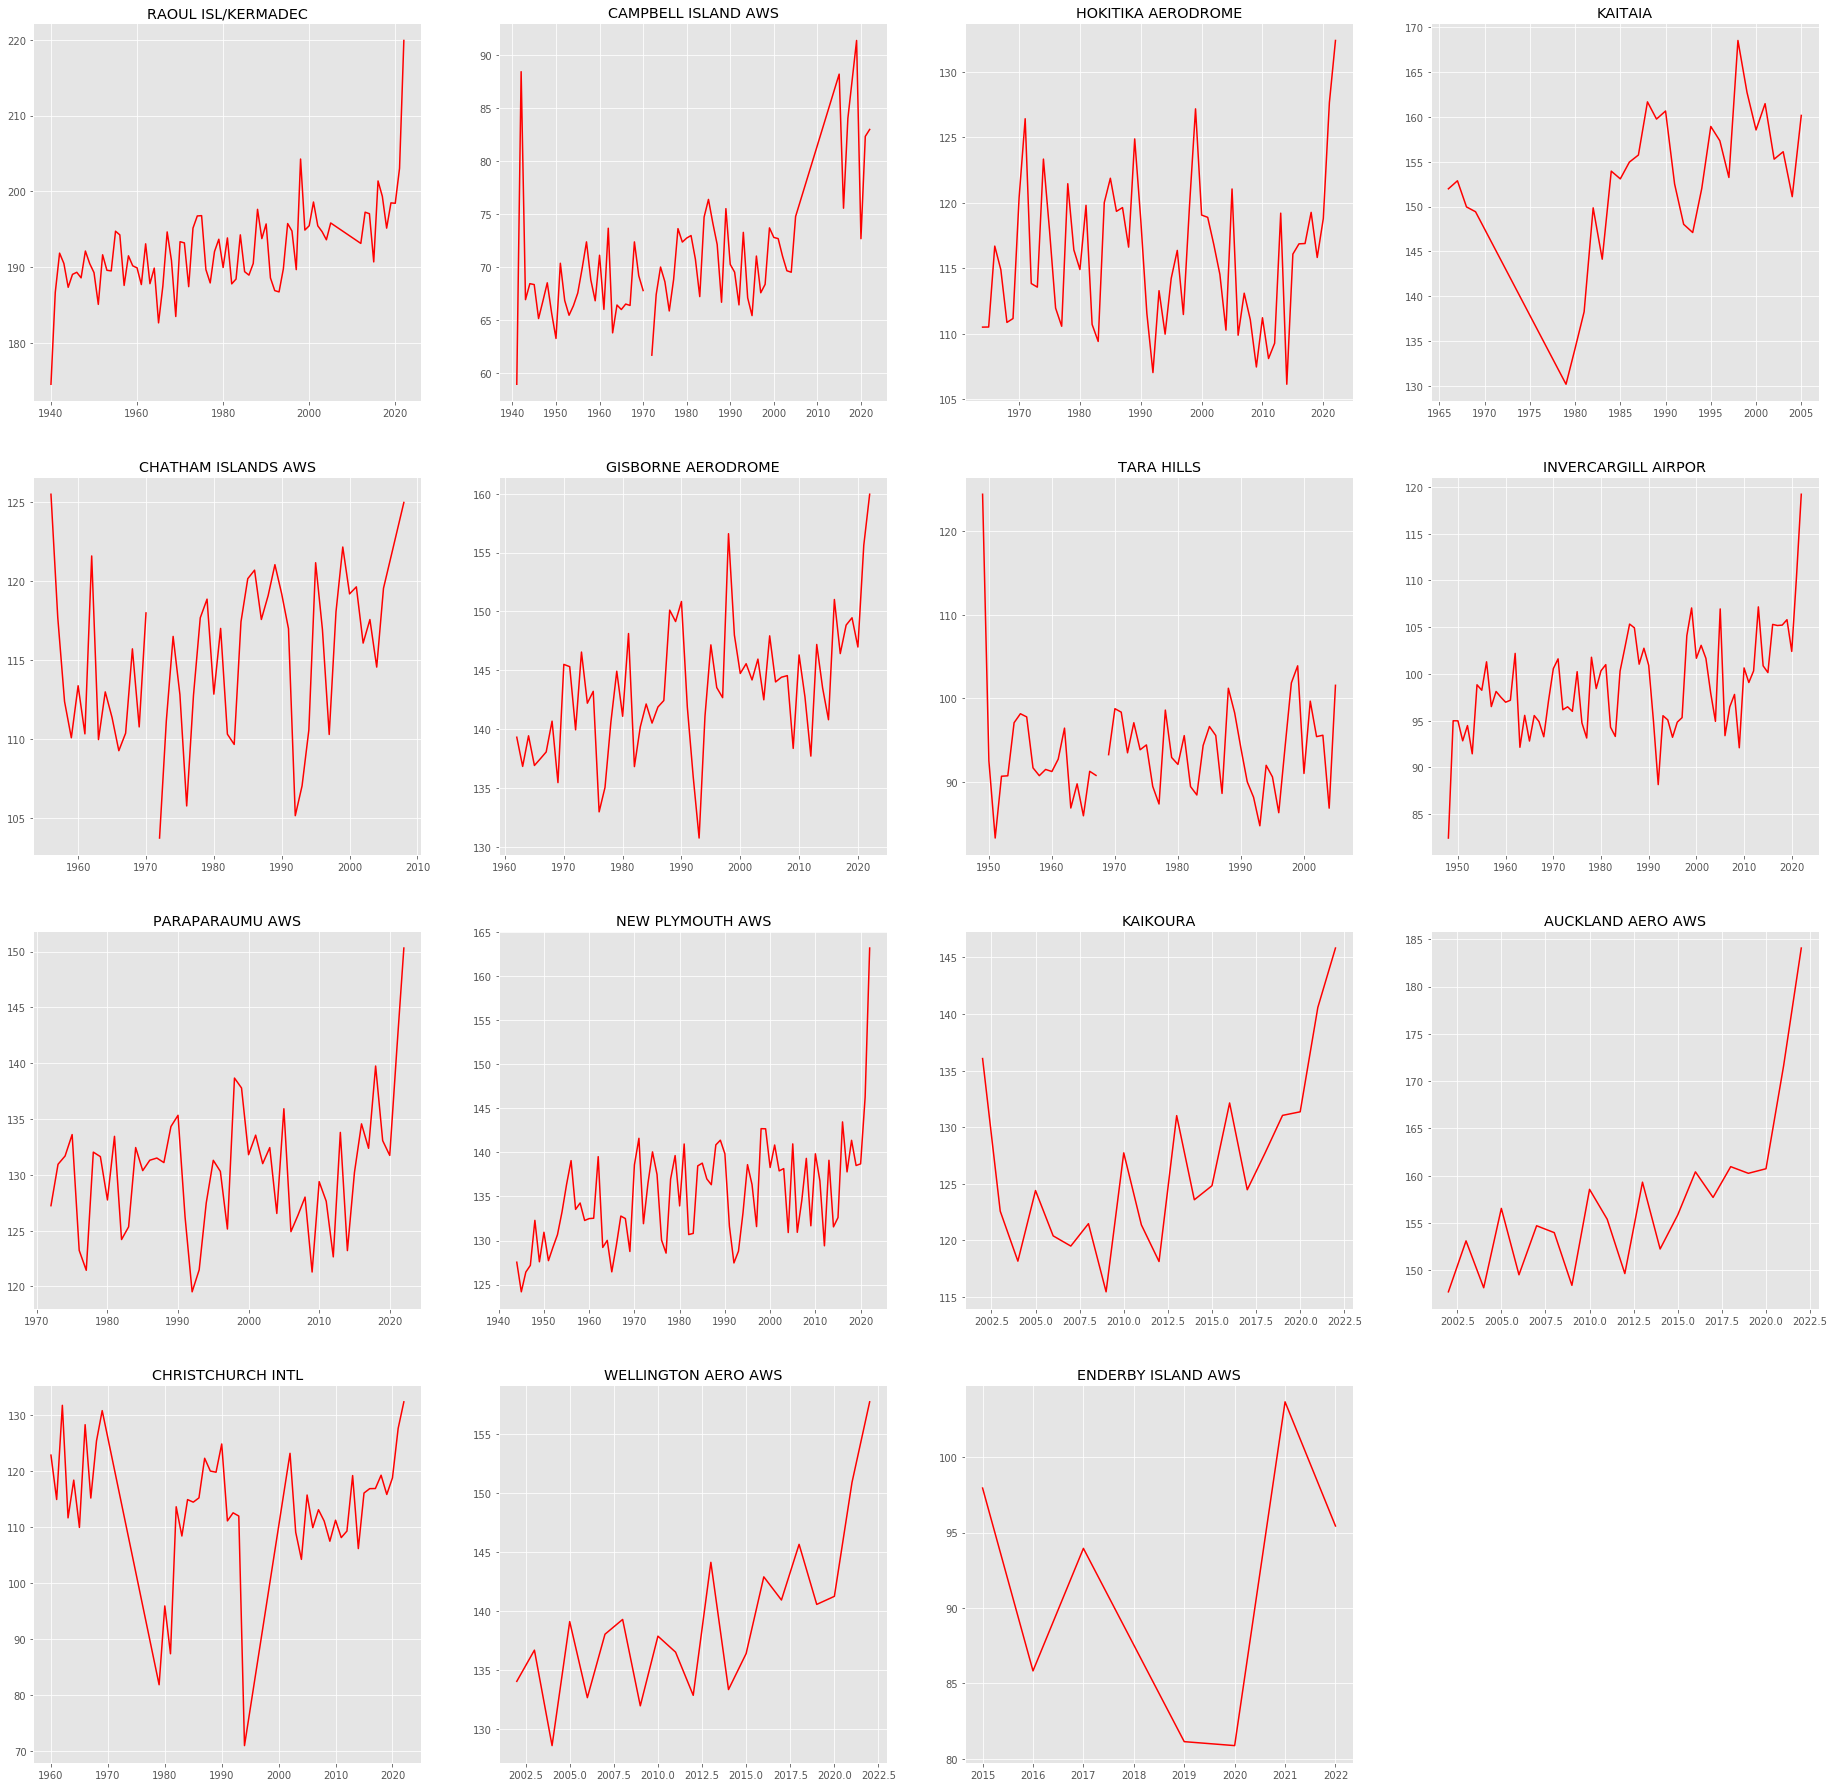

In [174]:
fig1 = plt.figure(figsize=(32, 32))


for i,NAME in enumerate(stations_plot):
    station_df = data.loc[data["STATION_NAME"] == NAME]
    station_df = pd.pivot_table(station_df,index='DATE',columns = 'ELEMENT',values='VALUE')
    station_df['AVERAGE'] = station_df.apply(lambda x: (x.TMIN + x.TMAX)/2, axis=1)
    station_df = station_df.groupby(station_df.index.year).mean()
    ax = fig1.add_subplot(4,4,(1+i))
    plt.title(NAME)
    ax.plot(station_df.index,station_df['AVERAGE'],color='red')


In [124]:
rainfall_average = (
daily_all
.filter(daily_all.ELEMENT =="PRCP")
.join(
stations
.select(["ID", "COUNTRY_NAME"]),
on="ID",
how="left")
.withColumn("YEAR", F.trim(F.substring(F.col("DATE"),1,4)))
    .groupby("YEAR", "COUNTRY_NAME")
    .agg({"VALUE":"Average"})
    .withColumnRenamed("avg(VALUE)", "AVERAGE_RAINFALL")
    .orderBy("AVERAGE_RAINFALL", ascending = False)
    .join(
    stations
    .select(["CODE", "COUNTRY_NAME"]),
    on="COUNTRY_NAME",
    how="left"))

rainfall_average.show()

+------------+----+------------------+----+
|COUNTRY_NAME|YEAR|  AVERAGE_RAINFALL|CODE|
+------------+----+------------------+----+
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|    Malaysia|2011| 83.88685127452779|  MY|
|        Laos|2011|136.28202247191012|  LA|
|        Laos|2011|136.28202247191012|  LA|
|        Laos|2011|136.28202247191012|  LA|
|        Laos|2011|136.282022471

In [125]:
rainfall_average.count()

20881736

In [161]:
max_rain = rainfall_average.groupby("COUNTRY_NAME").agg(F.max("AVERAGE_RAINFALL").alias("MAX_RAIN"))

max_rain.select([F.max("MAX_RAIN")]).show()

+-------------+
|max(MAX_RAIN)|
+-------------+
|       4361.0|
+-------------+



In [170]:
max_rain_avg = max_rain.select([F.max("MAX_RAIN")]).collect()[0][0]
max_rain.filter(max_rain.MAX_RAIN == max_rain_avg).show()


+-----------------+--------+
|     COUNTRY_NAME|MAX_RAIN|
+-----------------+--------+
|Equatorial Guinea|  4361.0|
+-----------------+--------+



In [127]:
rainfall_average.write.csv("hdfs///user/ndu31/outputs/ghcnd/rainfall_average.csv", header=True, mode="overwrite")

In [178]:
rainfalls = (spark.read.format("com.databricks.spark.csv")
              .option("header", "true")
              .option("inferSchema", "false")
              .load("hdfs///user/ndu31/outputs/ghcnd/rainfall_average.csv"))
rainfalls.show() 

+------------+----+------------------+----+
|COUNTRY_NAME|YEAR|  AVERAGE_RAINFALL|CODE|
+------------+----+------------------+----+
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.049035772281254|  MX|
|      Mexico|2010|28.0490357722

In [186]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()